# TBX5 - upbm pipeline inference

In [1]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(readxl)
library(upbm)
library(upbmAux)
theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuan

## variables

In [2]:
tf <- "TBX5"

motif <- "AGGTGT"
rc_motif <- "ACACCT"

ref_condition <- "TBX5C05-REF"

datdir <- "../../../../data/internal/pbms/gpr_files"
sampdir <- "../../../../data/internal/pbms/samp_sheets"

tf_file <- paste0("../../../../data/internal/pbms/upbm_processed/", tf, "-alexa-preprocessed.rds")
tf_file

[1] "../../../../data/internal/pbms/upbm_processed/TBX5-alexa-preprocessed.rds"

## 1. load preprocessed data

In [3]:
tf_ap <- readRDS(tf_file)
head(tf_ap)

class: PBMExperiment 
dim: 6 8 
metadata(0):
assays(4): normalized fore back spatialbias
rownames: NULL
rowData names(4): Column Row probeID Sequence
colnames(8): s1 s5 ... s21 s24
colData names(13): ...1 date ... acrossRepMultScale acrossRepAddScale
probeCols(4): Column Row probeID Sequence
probeFilter names(0): 
probeTrim: 1 36

## 2. fit probe model

In [4]:
alexa_pfit <- probeFit(tf_ap, stratify = "condition")
head(alexa_pfit)

class: PBMExperiment 
dim: 6 3 
metadata(0):
assays(3): beta sd df
rownames: NULL
rowData names(4): Column Row probeID Sequence
colnames(3): TBX5C05-REF TBX5A05 TBX5B05
colData names(0):
probeCols(4): Column Row probeID Sequence
probeFilter names(0): 
probeTrim: 1 36

In [5]:
pfit_dat <- broom::tidy(alexa_pfit, assay = c("beta", "sd"))
head(pfit_dat)

Column,Row,probeID,Sequence,cname,beta,sd
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>
6,1,dBr_14334_Jan07,GGTGTGAGTCCATTTCGTCAAACCAACGCAACAGGT,TBX5C05-REF,10.465088,0.2526282
6,1,dBr_14334_Jan07,GGTGTGAGTCCATTTCGTCAAACCAACGCAACAGGT,TBX5A05,9.939171,0.3572702
6,1,dBr_14334_Jan07,GGTGTGAGTCCATTTCGTCAAACCAACGCAACAGGT,TBX5B05,11.295894,0.5052564
7,1,dBr_06208_Jan07,CAGTCTAAGTTTTCGGATTACCATTAGAAATTGATG,TBX5C05-REF,9.863105,0.2015897
7,1,dBr_06208_Jan07,CAGTCTAAGTTTTCGGATTACCATTAGAAATTGATG,TBX5A05,9.130042,0.2850908
7,1,dBr_06208_Jan07,CAGTCTAAGTTTTCGGATTACCATTAGAAATTGATG,TBX5B05,9.528967,0.4031793


## 3. plot cross-replicate summarized probe intensities

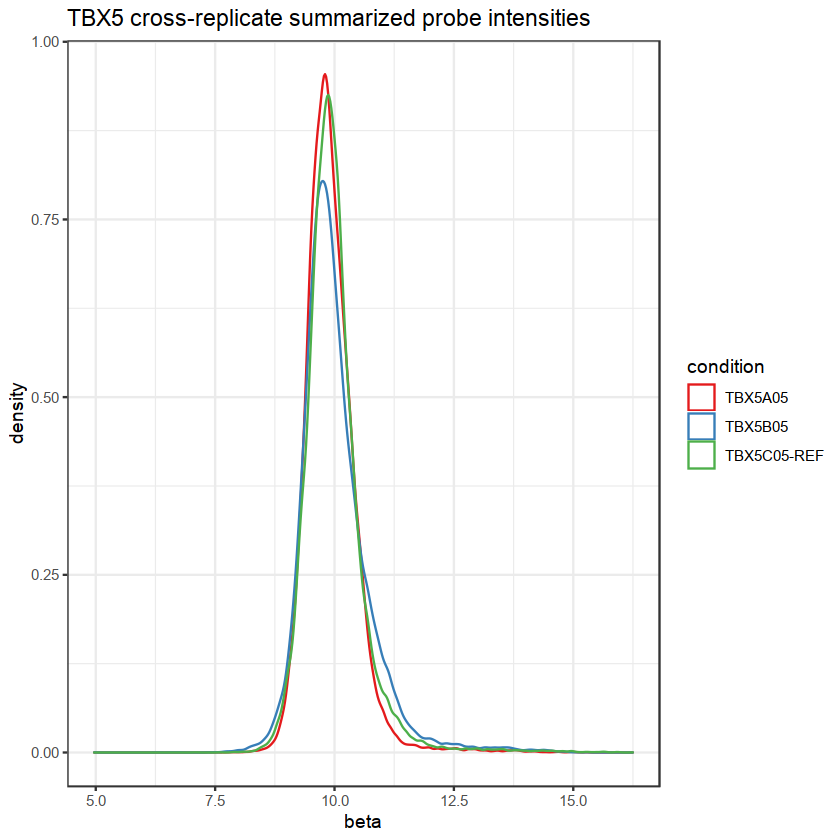

In [6]:
ggplot(pfit_dat, aes(x = beta, color = cname)) +
    geom_density() +
    scale_color_brewer("condition", palette = "Set1") +
    theme_bw() +
    ggtitle(paste(tf, "cross-replicate summarized probe intensities"))

## 4. fit k-mer model

In [7]:
alexa_kfit <- kmerFit(alexa_pfit, kmers = uniqueKmers(8L),
                      baseline = ref_condition)
alexa_kfit

class: SummarizedExperiment 
dim: 32896 3 
metadata(1): baseline
assays(5): affinityEstimate affinityVariance contrastDifference
  contrastAverage contrastVariance
rownames: NULL
rowData names(1): seq
colnames(3): TBX5C05-REF TBX5A05 TBX5B05
colData names(0):

## 5. test for k-mer affinity

In [8]:
alexa_pa <- kmerTestAffinity(alexa_kfit)
alexa_pa

class: SummarizedExperiment 
dim: 32896 3 
metadata(0):
assays(6): affinityEstimate affinityVariance ... affinityP affinityQ
rownames: NULL
rowData names(1): seq
colnames(3): TBX5C05-REF TBX5A05 TBX5B05
colData names(0):

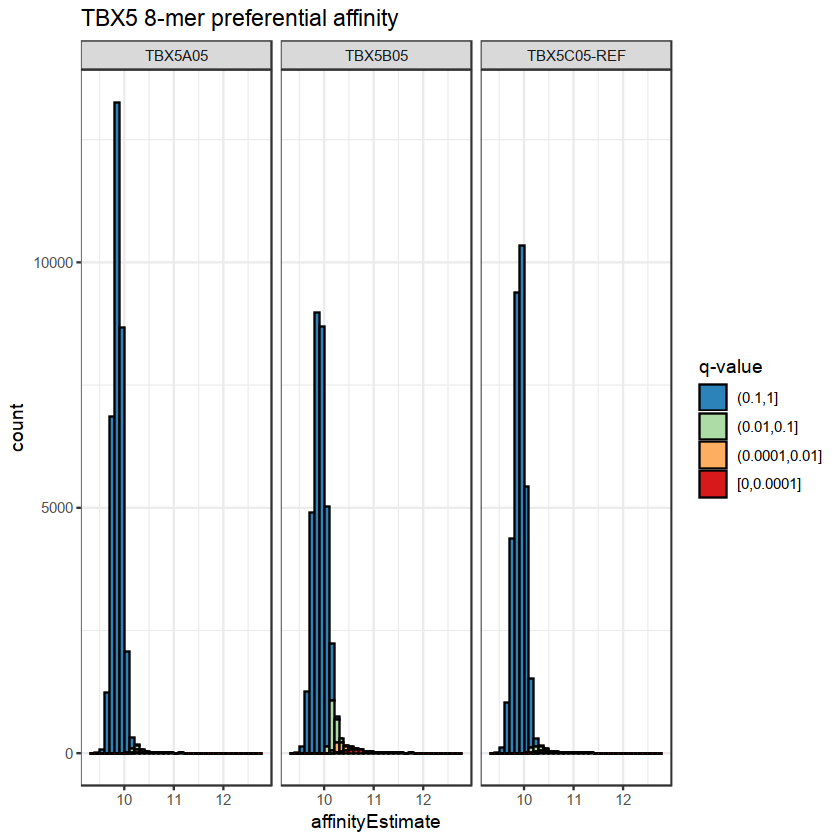

In [9]:
pa_dat <- broom::tidy(alexa_pa, c("affinityEstimate", "affinityQ"))

pa_dat %>%
    dplyr::mutate(affinityQ = cut(affinityQ, c(1e0, 1e-1, 1e-2, 1e-4, 0),
                                  include.lowest = TRUE),
                  affinityQ = factor(affinityQ, levels = rev(levels(affinityQ)))) %>%
    ggplot(aes(x = affinityEstimate, fill = affinityQ)) +
    geom_histogram(binwidth = .1, boundary = 10, color = 'black', position = "stack", alpha = 1) +
    scale_fill_brewer("q-value", palette = "Spectral", direction = -1, drop = FALSE,
                      na.value = "black") +
    theme_bw() +
    facet_wrap( ~ cname, nrow = 1) +
    ggtitle(paste(tf,"8-mer preferential affinity"))

In [10]:
kfit_dat <- broom::tidy(alexa_kfit, c("affinityEstimate", "affinityVariance", "affinityQ",
                                      "contrastDifference", "contrastAverage",
                                      "contrastVariance"))

kfit_dat <- kfit_dat %>%
    dplyr::mutate(contains_any_motif = case_when(grepl(motif, seq) | grepl(rc_motif, seq) ~ paste("*", tf, "k-mer"),
                                       !grepl(motif, seq) & !grepl(rc_motif, seq) ~ "other k-mer"))


head(kfit_dat)

seq,cname,affinityEstimate,affinityVariance,contrastDifference,contrastAverage,contrastVariance,contains_any_motif
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AAAAAAAA,TBX5C05-REF,10.028611,0.004803049,NA,NA,NA,other k-mer
AAAAAAAA,TBX5A05,9.931881,0.003411939,-0.096729591,9.980246,0.003536125,other k-mer
AAAAAAAA,TBX5B05,9.903240,0.006690214,-0.125370831,9.965926,0.003226624,other k-mer
AAAAAAAC,TBX5C05-REF,9.956585,0.001912345,NA,NA,NA,other k-mer
AAAAAAAC,TBX5A05,9.957827,0.003953165,0.001242024,9.957206,0.003823328,other k-mer
AAAAAAAC,TBX5B05,9.934673,0.007408185,-0.021912511,9.945629,0.005728191,other k-mer


## 6. test differential affinity across proteins (for a given k-mer)

In [11]:
alexa_da <- kmerTestContrast(alexa_kfit)
alexa_da

class: SummarizedExperiment 
dim: 32896 3 
metadata(0):
assays(6): contrastAverage contrastDifference ... contrastP contrastQ
rownames: NULL
rowData names(1): seq
colnames(3): TBX5C05-REF TBX5A05 TBX5B05
colData names(0):

In [12]:
da_dat <- broom::tidy(alexa_da, c("contrastAverage", "contrastDifference",
                                  "contrastQ"))

da_dat <- da_dat %>%
    dplyr::filter(cname != ref_condition) %>%
    dplyr::mutate(contrastQ_cut = cut(contrastQ, c(1e0, 1e-1, 1e-2, 1e-3, 0),
                                  include.lowest = TRUE),
                  contrastQ_cut = factor(contrastQ_cut, levels = rev(levels(contrastQ_cut))))

In [13]:
da_dat$contains_motif <- grepl(motif, da_dat$seq)
da_dat$contains_rc_motif <- grepl(rc_motif, da_dat$seq)
da_dat$contains_any_motif <- ifelse(da_dat$contains_motif | da_dat$contains_rc_motif, paste(tf, "k-mer"), "*other k-mer")

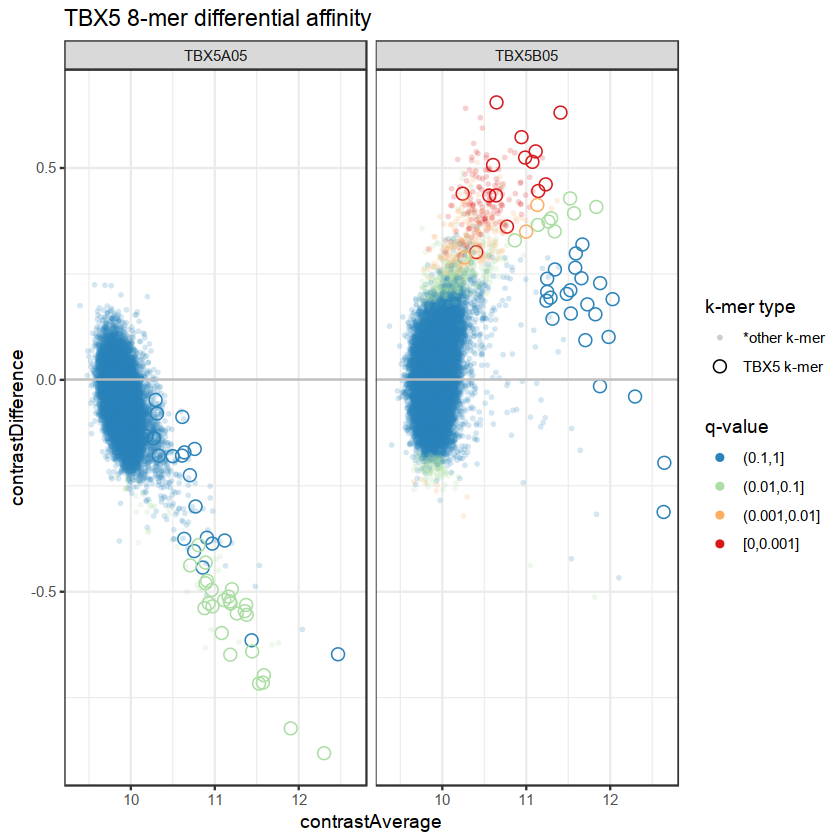

In [14]:
da_dat %>%
    ggplot(aes(x = contrastAverage, y = contrastDifference,
               color = contrastQ_cut, shape = contains_any_motif, 
               size = contains_any_motif, alpha = contains_any_motif)) +
    geom_point() +
    scale_color_brewer("q-value", palette = "Spectral", direction = -1, drop = FALSE,
                       na.value = "black") +
    scale_size_manual("k-mer type", values=c(1, 3)) +
    scale_shape_manual("k-mer type", values=c(16, 21)) +
    scale_alpha_manual("k-mer type", values=c(0.2, 1)) +
    geom_hline(color = 'gray', yintercept = 0) + 
    theme_bw() +
    guides(color = guide_legend(override.aes = list(alpha = 1))) +
    facet_grid(. ~ cname) +
    ggtitle(paste(tf, "8-mer differential affinity"))

## 7. write files

In [15]:
write.csv(kfit_dat, file=file.path("../../../../data/processed/pbms", paste0(tf, "kfit_dat.csv")), row.names=FALSE)
write.csv(da_dat, file=file.path("../../../../data/processed/pbms", paste0(tf, "da_dat.csv")), row.names=FALSE)

## 8. make sequence logos

In [16]:
source("../../../pbm_utils.r")

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: RSQLite

Loading required package: parallel

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern



Attaching package: ‘seqinr’


The following object is masked from ‘package:seqLogo’:

    consensus


The following object is masked from ‘package:Biostrings’:

    translate


The following object is masked from ‘package:matrixStats’:

    count


The following object is masked from ‘package:dplyr’:

    count




### sequence logo for each isoform

In [17]:
n_to_plot <- 50

In [18]:
pa_dat_sort <- pa_dat[order(pa_dat$affinityQ, decreasing = FALSE), ]

pa_ref <- head(pa_dat_sort[pa_dat_sort$cname == "TBX5C05-REF",], n_to_plot)
print(nrow(pa_ref))

pa_a <- head(pa_dat_sort[pa_dat_sort$cname == "TBX5A05",], n_to_plot)
print(nrow(pa_a))

pa_b <- head(pa_dat_sort[pa_dat_sort$cname == "TBX5B05",], n_to_plot)
print(nrow(pa_b))

[1] 50
[1] 50
[1] 50


In [19]:
pa_ref_pwm <- pwm_from_ordered_list(pa_ref$seq, orientation_motif="CAC")
pa_a_pwm <- pwm_from_ordered_list(pa_a$seq, orientation_motif="CAC")
pa_b_pwm <- pwm_from_ordered_list(pa_b$seq, orientation_motif="CAC")

[1] 50

Time difference of 0.16 secs
Determining distance matrix based on shared 6-mers:

Time difference of 0.06 secs

Clustering into groups by similarity:

Time difference of 0.07 secs

Aligning Sequences:

Time difference of 0.25 secs

Iteration 1 of 2:

Determining distance matrix based on alignment:

Time difference of 0.06 secs

Reclustering into groups by similarity:

Time difference of 0.07 secs

Realigning Sequences:

Time difference of 0.26 secs

Iteration 2 of 2:

Determining distance matrix based on alignment:

Time difference of 0.06 secs

Reclustering into groups by similarity:

Time difference of 0.07 secs

Realigning Sequences:

Time difference of 0.05 secs

Refining the alignment:

Time difference of 0.02 secs

[1] 50

Time difference of 0.16 secs
Determining distance matrix based on shared 6-mers:

Time difference of 0.06 secs

Clustering into groups by similarity:

Time difference of 0.07 secs

Aligning Sequences:

Time difference of 0.24 secs

Iteration 1 of 2:

De

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


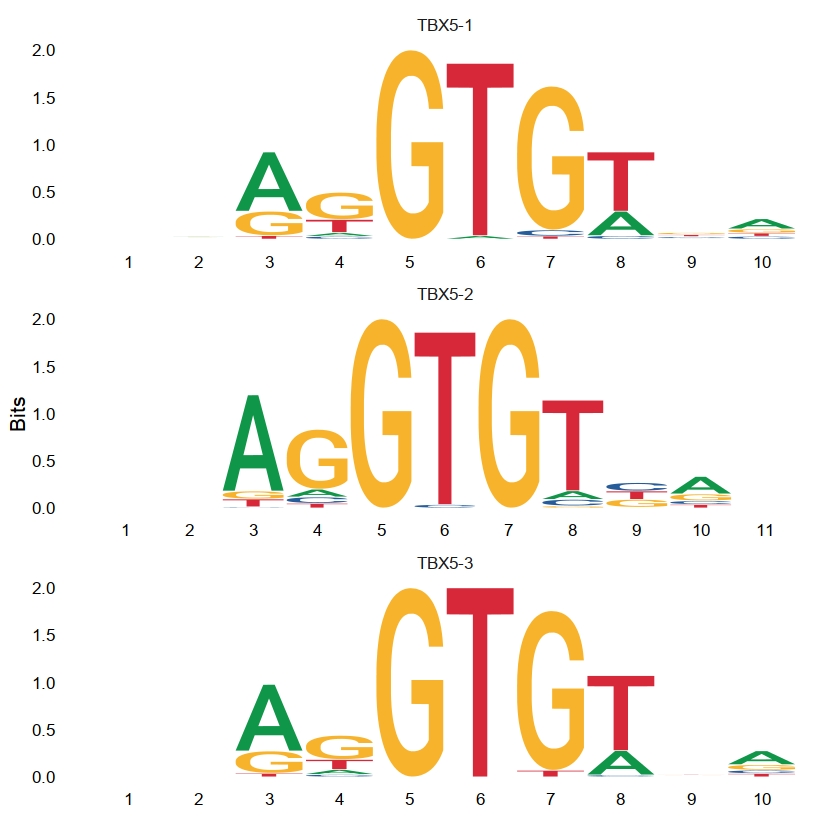

In [20]:
pwms <- list('TBX5-1'=pa_ref_pwm, 'TBX5-2'=pa_b_pwm, 'TBX5-3'=pa_a_pwm)
ggseqlogo(pwms, ncol=1)

In [21]:
options(repr.plot.width=1.5, repr.plot.height=1, repr.plot.pointsize=9)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


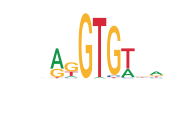

In [22]:
ggseqlogo(pwms[[1]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_blank(),
                                     axis.title.y = element_blank())
ggsave("../../../../figures/TBX5-ref_pbm_seqlogo.pdf", width=1.5, height=1)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


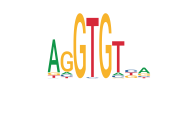

In [23]:
ggseqlogo(pwms[[2]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_blank(),
                                     axis.title.y = element_blank())
ggsave("../../../../figures/TBX5-2_pbm_seqlogo.pdf", width=1.5, height=1)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


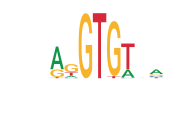

In [24]:
ggseqlogo(pwms[[3]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_blank(),
                                     axis.title.y = element_blank())
ggsave("../../../../figures/TBX5-3_pbm_seqlogo.pdf", width=1.5, height=1)

In [25]:
options(repr.plot.width=2.5, repr.plot.height=2, repr.plot.pointsize=9)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


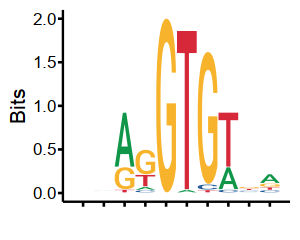

In [26]:
ggseqlogo(pwms[[1]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_text(margin = margin(r=1)),
                                     axis.line.x = element_line(color="black", size=0.5),
                                     axis.line.y = element_line(color="black", size=0.5),
                                     axis.ticks.x = element_line(color="black"),
                                     axis.ticks.y = element_line(color="black"))
ggsave("../../../../figures/TBX5-ref_pbm_seqlogo_larger.pdf", width=2.5, height=2)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


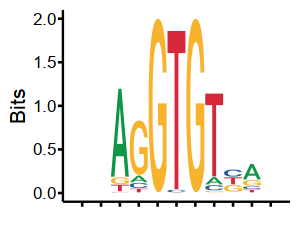

In [27]:
ggseqlogo(pwms[[2]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_text(margin = margin(r=1)),
                                     axis.line.x = element_line(color="black", size=0.5),
                                     axis.line.y = element_line(color="black", size=0.5),
                                     axis.ticks.x = element_line(color="black"),
                                     axis.ticks.y = element_line(color="black"))
ggsave("../../../../figures/TBX5-2_pbm_seqlogo_larger.pdf", width=2.5, height=2)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


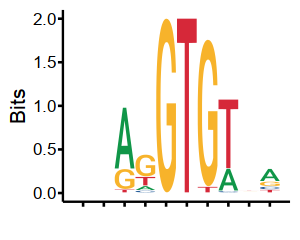

In [28]:
ggseqlogo(pwms[[3]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_text(margin = margin(r=1)),
                                     axis.line.x = element_line(color="black", size=0.5),
                                     axis.line.y = element_line(color="black", size=0.5),
                                     axis.ticks.x = element_line(color="black"),
                                     axis.ticks.y = element_line(color="black"))
ggsave("../../../../figures/TBX5-3_pbm_seqlogo_larger.pdf", width=2.5, height=2)

### sequence logo of moderate affinity significant 8mers for TBX5-2

In [29]:
da_q_thresh <- 0.001

In [30]:
da_b <- da_dat[da_dat$contrastQ < da_q_thresh, ]
da_b <- da_b[da_b$cname=="TBX5B05", ]
print(nrow(da_b))

[1] 162


In [31]:
ref_highest <- pa_ref$seq[[1]]
ref_highest

[1] "AGGTGTGA"

In [32]:
da_b_pwm <- pwm_from_ordered_list(c(ref_highest, da_b$seq), remove_first = TRUE, orientation_motif = "CAC")

[1] 163

Time difference of 0.13 secs
Determining distance matrix based on shared 6-mers:

Time difference of 0.11 secs

Clustering into groups by similarity:

Time difference of 0.14 secs

Aligning Sequences:

Time difference of 0.61 secs

Iteration 1 of 2:

Determining distance matrix based on alignment:

Time difference of 0.1 secs

Reclustering into groups by similarity:

Time difference of 0.14 secs

Realigning Sequences:

Time difference of 0.65 secs

Iteration 2 of 2:

Determining distance matrix based on alignment:

Time difference of 0.11 secs

Reclustering into groups by similarity:

Time difference of 0.15 secs

Realigning Sequences:

Time difference of 0.45 secs

Refining the alignment:

Time difference of 0.07 secs



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


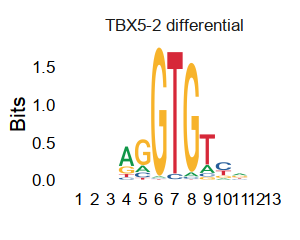

In [33]:
pwms <- list('TBX5-2 differential'=da_b_pwm)
ggseqlogo(pwms, ncol=1)

In [34]:
options(repr.plot.width=1.5, repr.plot.height=1, repr.plot.pointsize=9)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


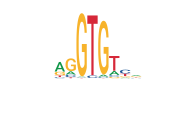

In [35]:
ggseqlogo(pwms[[1]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_blank(),
                                     axis.title.y = element_blank())
ggsave("../../../../figures/TBX5-2_differential_pbm_seqlogo.pdf", width=1.5, height=1)

In [36]:
options(repr.plot.width=2.5, repr.plot.height=2, repr.plot.pointsize=9)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


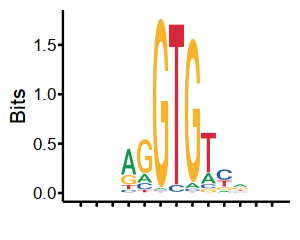

In [37]:
ggseqlogo(pwms[[1]], ncol=1) + theme(axis.text.x = element_blank(),
                                     axis.text.y = element_text(margin = margin(r=1)),
                                     axis.line.x = element_line(color="black", size=0.5),
                                     axis.line.y = element_line(color="black", size=0.5),
                                     axis.ticks.x = element_line(color="black"),
                                     axis.ticks.y = element_line(color="black"))
ggsave("../../../../figures/TBX5-2_differential_pbm_seqlogo_larger.pdf", width=2.5, height=2)